In [1]:
!curl https://certs.secureserver.net/repository/sf-class2-root.crt -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1468  100  1468    0     0   6096      0 --:--:-- --:--:-- --:--:--  6116


In [2]:
%pip install cassandra-sigv4

Note: you may need to restart the kernel to use updated packages.


In [3]:
from cassandra.cluster import Cluster
from ssl import SSLContext, PROTOCOL_TLSv1_2, CERT_REQUIRED
from cassandra_sigv4.auth import SigV4AuthProvider
import boto3

# ssl setup
ssl_context = SSLContext(PROTOCOL_TLSv1_2)
ssl_context.load_verify_locations('sf-class2-root.crt')  # change your file path for locating the certificate
ssl_context.verify_mode = CERT_REQUIRED

# boto3 session setup
boto_session = boto3.Session(region_name="us-east-2")  # this AWS credentials is specific to `us-east-2` region

/tmp/ipykernel_18298/332746716.py:7: DeprecationWarning: ssl.PROTOCOL_TLSv1_2 is deprecated
  ssl_context = SSLContext(PROTOCOL_TLSv1_2)


In [4]:
auth_provider = SigV4AuthProvider(boto_session)

In [5]:
#cluster setup 
cluster = Cluster(['cassandra.us-east-2.amazonaws.com'], 
                  ssl_context=ssl_context, 
                  auth_provider=auth_provider, 
                  port=9142)  # TLS only communicates on port 9142

In [6]:
# establishing connection to Keyspace
session = cluster.connect()

In [7]:
from cassandra.cluster import ExecutionProfile, EXEC_PROFILE_DEFAULT
from cassandra import ConsistencyLevel


# Define execution profile with LOCAL_QUORUM
execution_profile = ExecutionProfile(
    consistency_level=ConsistencyLevel.LOCAL_QUORUM
)

# Cluster setup with correct profile
cluster = Cluster(
    ['cassandra.us-east-2.amazonaws.com'],
    ssl_context=ssl_context,
    auth_provider=auth_provider,
    port=9142,
    execution_profiles={EXEC_PROFILE_DEFAULT: execution_profile}
)

# establishing connection to Keyspace
session = cluster.connect()
session.set_keyspace('homework2')

In [8]:
import pandas as pd

ADMISSIONS = pd.read_csv("ADMISSIONS.csv")
D_ICD_PROCEDURES = pd.read_csv("D_ICD_PROCEDURES.csv")
DRGCODES = pd.read_csv("DRGCODES.csv")
ICUSTAYS = pd.read_csv("ICUSTAYS.csv")
PATIENTS = pd.read_csv("PATIENTS.csv")
PRESCRIPTIONS = pd.read_csv("PRESCRIPTIONS.csv")
PROCEDURES_ICD = pd.read_csv("PROCEDURES_ICD.csv")

**Question 1: Create a summary of type of drugs and their total amount used by ethnicity. Report the top usage in each ethnicity group. You may have to make certain assumptions in calculating their total amount.**

A. 

In [9]:
session.execute("""
    CREATE TABLE IF NOT EXISTS top_drug_by_ethnicity (
        ethnicity text,                -- Partition Key (mandatory)
        drug_type text,                -- Clustering Column
        drug_count int,                -- Data Value
        PRIMARY KEY ((ethnicity), drug_count, drug_type)
    ) WITH CLUSTERING ORDER BY (drug_count DESC, drug_type ASC);
""")

B.

In [10]:
merged = pd.merge(
    ADMISSIONS[['hadm_id', 'ethnicity']],
    PRESCRIPTIONS[['hadm_id', 'drug_type']],
    on='hadm_id'
)

drug_counts = merged.groupby(['ethnicity', 'drug_type']).size().reset_index(name='drug_count')

insert_stmt = session.prepare("""
    INSERT INTO top_drug_by_ethnicity (ethnicity, drug_type, drug_count)
    VALUES (?, ?, ?)
""")

C.

In [11]:

for _, row in drug_counts.iterrows():
    bound = insert_stmt.bind((row['ethnicity'], row['drug_type'], int(row['drug_count'])))
    session.execute(bound)

ethnicities = drug_counts['ethnicity'].unique()

for eth in ethnicities:
    result = session.execute("""
        SELECT * FROM top_drug_by_ethnicity
        WHERE ethnicity = %s LIMIT 1
    """, [eth])
    for row in result:
        print(f"Ethnicity: {row.ethnicity}, Top Drug: {row.drug_type}, Count: {row.drug_count}")

Ethnicity: AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE, Top Drug: MAIN, Count: 200
Ethnicity: ASIAN, Top Drug: MAIN, Count: 121
Ethnicity: BLACK/AFRICAN AMERICAN, Top Drug: MAIN, Count: 476
Ethnicity: HISPANIC OR LATINO, Top Drug: MAIN, Count: 226
Ethnicity: HISPANIC/LATINO - PUERTO RICAN, Top Drug: MAIN, Count: 860
Ethnicity: OTHER, Top Drug: MAIN, Count: 72
Ethnicity: UNABLE TO OBTAIN, Top Drug: MAIN, Count: 89
Ethnicity: UNKNOWN/NOT SPECIFIED, Top Drug: MAIN, Count: 245
Ethnicity: WHITE, Top Drug: MAIN, Count: 5420


D. 

In [12]:
result = session.execute("SELECT * FROM top_drug_by_ethnicity")
df_result = pd.DataFrame(result.all())
print(df_result)

                                           ethnicity  drug_count drug_type
0                                              OTHER          72      MAIN
1                             BLACK/AFRICAN AMERICAN         476      MAIN
2                                              WHITE        5420      MAIN
3                                              ASIAN         121      MAIN
4                     HISPANIC/LATINO - PUERTO RICAN         860      MAIN
5                              UNKNOWN/NOT SPECIFIED         245      MAIN
6                                   UNABLE TO OBTAIN          89      MAIN
7  AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...         200      MAIN
8                                 HISPANIC OR LATINO         226      MAIN


Above is the code for Question 1, with the resulting table (extraction) with desired data above.

***Question 2: Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80). Report the top three procedures, along with the name of the procedures, performed in each age group.***

A.

In [13]:
session.execute("""
    CREATE TABLE IF NOT EXISTS top_procedures_by_age_rank (
    age_group TEXT,
    procedure_count INT,
    procedure_name TEXT,
    PRIMARY KEY (age_group, procedure_count, procedure_name)
) WITH CLUSTERING ORDER BY (procedure_count DESC, procedure_name ASC);""")

B.

In [14]:

ADMISSIONS['admittime'] = pd.to_datetime(ADMISSIONS['admittime'], errors='coerce')
PATIENTS['dob'] = pd.to_datetime(PATIENTS['dob'], errors='coerce')

merged_adm = ADMISSIONS.merge(PATIENTS[['subject_id', 'dob']], on='subject_id', how='inner')

def compute_age(row):
    try:
        delta = row['admittime'] - row['dob']
        return delta.total_seconds() / (60 * 60 * 24 * 365.25)
    except:
        return None

merged_adm['age'] = merged_adm.apply(compute_age, axis=1)

merged_adm['age'] = merged_adm['age'].clip(upper=150)

merged_adm['age_group'] = pd.cut(
    merged_adm['age'],
    bins=[-1, 19, 49, 79, 150],
    labels=['0-19', '20-49', '50-79', '>80'])

procedures_with_age = PROCEDURES_ICD.merge(
    merged_adm[['hadm_id', 'age_group']],
    on='hadm_id',
    how='inner'
)

procedures_labeled = procedures_with_age.merge(
    D_ICD_PROCEDURES[['icd9_code', 'short_title']],
    on='icd9_code',
    how='left' 
)

procedures_labeled.rename(columns={'short_title': 'procedure_name'}, inplace=True)

procedure_counts = (
    procedures_labeled
    .groupby(['age_group', 'procedure_name'])
    .size()
    .reset_index(name='procedure_count')
)

procedure_counts = procedure_counts[procedure_counts['procedure_count'] > 0]

insert_stmt = session.prepare("""
    INSERT INTO top_procedures_by_age_rank (age_group, procedure_count, procedure_name)
    VALUES (?, ?, ?)
""")

for _, row in procedure_counts.iterrows():
    session.execute(insert_stmt, (
        row['age_group'],
        int(row['procedure_count']),
        row['procedure_name']
    ))

/tmp/ipykernel_18298/4236425396.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['age_group', 'procedure_name'])


C.

In [15]:
age_groups = ['0-19', '20-49', '50-79', '>80']

results = []
for group in age_groups:
    rows = session.execute(
        """
        SELECT procedure_name, procedure_count
        FROM top_procedures_by_age_rank
        WHERE age_group = %s
        LIMIT 3;
        """,
        (group,)
    )
    for row in rows:
        results.append({
            'age_group': group,
            'procedure_name': row.procedure_name,
            'procedure_count': row.procedure_count
        })


D.

In [16]:
top_3_df = pd.DataFrame(results)
print(top_3_df)

   age_group            procedure_name  procedure_count
0       0-19           Venous cath NEC                2
1       0-19  Applic ext fix dev-femur                1
2       0-19         Atlas-axis fusion                1
3      20-49           Venous cath NEC                9
4      20-49   Entral infus nutrit sub                7
5      20-49  Cont inv mec ven 96+ hrs                6
6      50-79           Venous cath NEC               25
7      50-79   Entral infus nutrit sub               22
8      50-79   Packed cell transfusion               13
9        >80           Venous cath NEC               16
10       >80   Packed cell transfusion               13
11       >80  Insert endotracheal tube                8


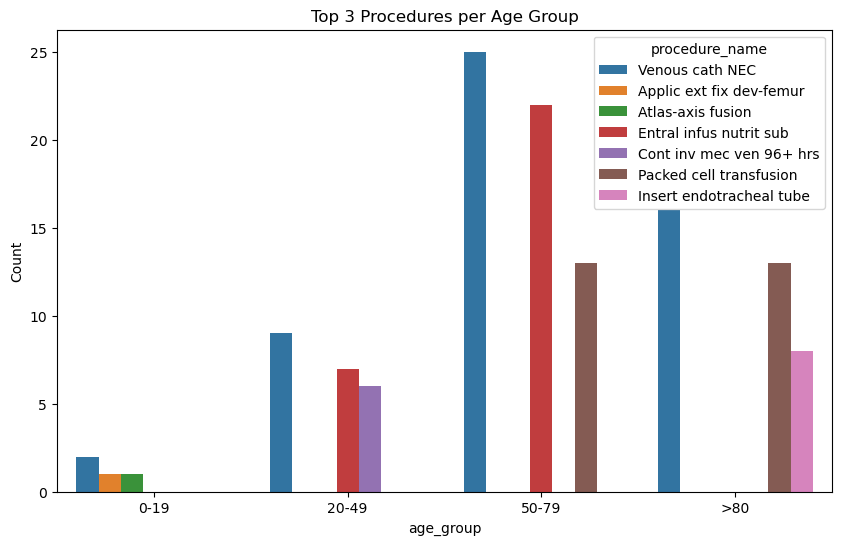

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=top_3_df, x='age_group', y='procedure_count', hue='procedure_name')
plt.title('Top 3 Procedures per Age Group')
plt.ylabel('Count')
plt.show()

**3. How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?**

A.

In [18]:
session.execute("DROP TABLE IF EXISTS icu_stay_records;")

In [19]:
session.execute("""
    CREATE TABLE IF NOT EXISTS icu_stay_records (
        uid UUID,
        stay_length INT,
        gender TEXT,
        ethnicity TEXT,
        PRIMARY KEY (uid)
    );
""")

B.

In [22]:
ICUSTAYS = pd.read_csv("ICUSTAYS.csv", parse_dates=['intime', 'outtime'])

ICUSTAYS['stay_length'] = (ICUSTAYS['outtime'] - ICUSTAYS['intime']).dt.days


merged_temp = ICUSTAYS.merge(ADMISSIONS[['hadm_id', 'subject_id', 'ethnicity']], on='hadm_id', how='left')
merged_temp.rename(columns={'subject_id_y': 'subject_id'}, inplace=True)
merged_icu = merged_temp.merge(PATIENTS[['subject_id', 'gender']], on='subject_id', how='left')

merged_icu = merged_icu.dropna(subset=['stay_length', 'gender', 'ethnicity'])
merged_icu = merged_icu[merged_icu['stay_length'] >= 0]

C.

In [23]:
from uuid import uuid4

insert_stmt = session.prepare("""
    INSERT INTO icu_stay_records (uid, stay_length, gender, ethnicity)
    VALUES (?, ?, ?, ?)
""")

for _, row in merged_icu.iterrows():
    session.execute(insert_stmt, (
        uuid4(),
        int(row['stay_length']),
        row['gender'],
        row['ethnicity']
    ))

D. 

In [24]:
rows = session.execute("SELECT gender, ethnicity, stay_length FROM icu_stay_records;")
icu_df = pd.DataFrame(rows)
print(icu_df['stay_length'].describe())

count    136.000000
mean       3.941176
std        6.226306
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       35.000000
Name: stay_length, dtype: float64


For Gender:

In [25]:
rows = session.execute("SELECT gender, stay_length FROM icu_stay_records;")
icu_gender_df = pd.DataFrame(rows)

gender_stats = icu_gender_df.groupby('gender')['stay_length'].agg(
    Q1=lambda x: x.quantile(0.25),
    Median='median',
    Q3=lambda x: x.quantile(0.75),
    Mean='mean',
    Std='std',
    Count='count'
).reset_index()

print(gender_stats)


  gender   Q1  Median   Q3      Mean       Std  Count
0      F  1.0     2.0  4.0  5.015873  7.879111     63
1      M  1.0     1.0  3.0  3.013699  4.164977     73


For Ethinicity:

In [26]:
rows = session.execute("SELECT ethnicity, stay_length FROM icu_stay_records;")
icu_ethnicity_df = pd.DataFrame(rows)

ethnicity_stats = icu_ethnicity_df.groupby('ethnicity')['stay_length'].agg(
    Q1=lambda x: x.quantile(0.25),
    Median='median',
    Q3=lambda x: x.quantile(0.75),
    Mean='mean',
    Std='std',
    Count='count'
).reset_index()

print(ethnicity_stats)

                                           ethnicity     Q1  Median     Q3  \
0  AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...   6.00    11.0  16.00   
1                                              ASIAN   1.75     3.5   5.25   
2                             BLACK/AFRICAN AMERICAN   0.50     3.0   7.50   
3                                 HISPANIC OR LATINO   3.00     3.0   9.00   
4                     HISPANIC/LATINO - PUERTO RICAN   1.00     2.0   2.00   
5                                              OTHER   0.00     0.0   0.50   
6                                   UNABLE TO OBTAIN  13.00    13.0  13.00   
7                              UNKNOWN/NOT SPECIFIED   2.00     2.0   4.00   
8                                              WHITE   1.00     1.5   3.00   

        Mean        Std  Count  
0  11.000000  14.142136      2  
1   3.500000   4.949747      2  
2   7.142857  11.186727      7  
3   7.000000   6.928203      3  
4   2.600000   3.157757     15  
5   0.333333   0.5773